# 1) A Position-Free Paradigm

In [1]:
import gurobipy as gp
from gurobipy import GRB

# Dados do contêiner
L, W, H = 12, 8, 8
Xo, Yo, Zo = 0, 0, 0
M = 100  # Número grande o suficiente

# Dados das caixas (li, wi, hi) e vi
boxes = [
    (6, 3, 2), (6, 3, 2),              # caixas 1-2
    (6, 4, 3), (6, 4, 3), (6, 4, 3),   # caixas 3-7
    (6, 4, 3), (6, 4, 3),
    (8, 3, 2), (8, 3, 2), (8, 3, 2),   # caixas 8-10
    (4, 3, 2), (4, 3, 2),              # caixas 11-12
    (4, 4, 3), (4, 4, 3), (4, 4, 3)    # caixas 13-15
]
m = len(boxes)
vi = [0.5 * (l * w * h) / (L * W * H) for l, w, h in boxes]

model = gp.Model("container_loading")

# Variáveis
p = model.addVars(m, vtype=GRB.BINARY, name="p")
x = model.addVars(m, vtype=GRB.CONTINUOUS, name="x")
y = model.addVars(m, vtype=GRB.CONTINUOUS, name="y")
z = model.addVars(m, vtype=GRB.CONTINUOUS, name="z")

a = model.addVars(m, m, vtype=GRB.BINARY, name="a")
b = model.addVars(m, m, vtype=GRB.BINARY, name="b")
c = model.addVars(m, m, vtype=GRB.BINARY, name="c")
d = model.addVars(m, m, vtype=GRB.BINARY, name="d")
e = model.addVars(m, m, vtype=GRB.BINARY, name="e")
f = model.addVars(m, m, vtype=GRB.BINARY, name="f")

# Função objetivo
model.setObjective(gp.quicksum(vi[i] * p[i] for i in range(m)), GRB.MAXIMIZE)

# Restrições
for i in range(m):
    li, wi, hi = boxes[i]

    # Dentro do contêiner
    model.addConstr(x[i] >= Xo * p[i])
    model.addConstr(y[i] >= Yo * p[i])
    model.addConstr(z[i] >= Zo * p[i])
    model.addConstr(x[i] + li <= Xo + L)
    model.addConstr(y[i] + wi <= Yo + W)
    model.addConstr(z[i] + hi <= Zo + H)

    for j in range(i+1, m):
        lj, wj, hj = boxes[j]

        model.addConstr(x[i] + li <= x[j] + (1 - a[i, j]) * M)
        model.addConstr(x[j] + lj <= x[i] + (1 - b[i, j]) * M)
        model.addConstr(y[i] + wi <= y[j] + (1 - c[i, j]) * M)
        model.addConstr(y[j] + wj <= y[i] + (1 - d[i, j]) * M)
        model.addConstr(z[i] + hi <= z[j] + (1 - e[i, j]) * M)
        model.addConstr(z[j] + hj <= z[i] + (1 - f[i, j]) * M)

        # Uma relação espacial por par
        model.addConstr(a[i, j] + b[i, j] + c[i, j] + d[i, j] + e[i, j] + f[i, j] >= p[i] + p[j] - 1)

# Rodar
model.setParam('TimeLimit', 120) #Limite de tempo, se não roda infinito
model.optimize()

# Imprimir solução
for i in range(m):
    if p[i].X > 0.5:
        print(f"Box {i+1} at ({x[i].X:.1f}, {y[i].X:.1f}, {z[i].X:.1f})")


Set parameter Username
Set parameter LicenseID to value 2687873
Academic license - for non-commercial use only - expires 2026-07-13
Set parameter TimeLimit to value 120
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
TimeLimit  120

Optimize a model with 825 rows, 1410 columns and 2820 nonzeros
Model fingerprint: 0x77f23c5a
Variable types: 45 continuous, 1365 integer (1365 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e-02, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 0.0234375
Presolve removed 138 rows and 768 columns
Presolve time: 0.02s
Presolved: 687 rows, 642 columns, 2538 nonzeros
Variable types: 45 continuous, 597 integer (597 binary)

Root relaxation: obje

## 1.1) Visualization

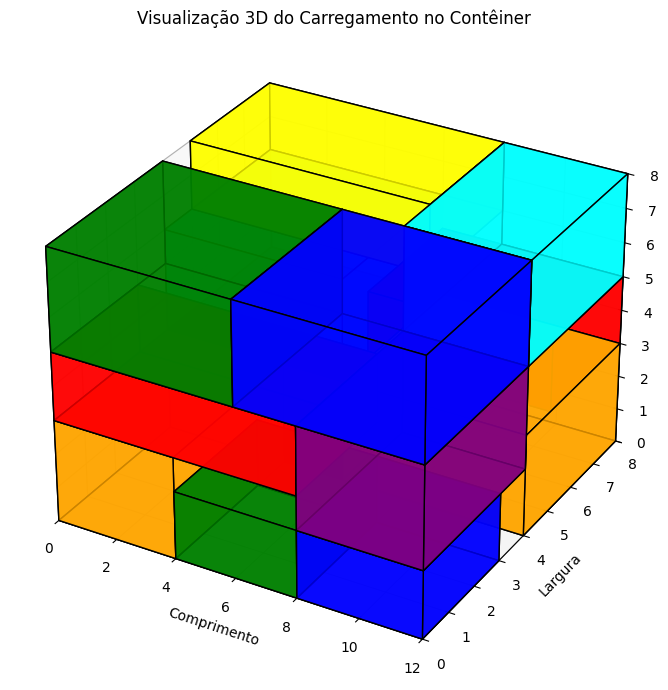

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Dimensões do contêiner
L, W, H = 12, 8, 8

# Dados das caixas (li, wi, hi)
boxes = [
    (6, 3, 2), (6, 3, 2), (6, 4, 3), (6, 4, 3), (6, 4, 3),
    (6, 4, 3), (6, 4, 3), (8, 3, 2), (8, 3, 2), (8, 3, 2),
    (4, 3, 2), (4, 3, 2), (4, 4, 3), (4, 4, 3), (4, 4, 3)
]

# Suponha que essas caixas foram carregadas, com as posições correspondentes
loaded_boxes = []

for i in range(m):
    if p[i].X > 0.5:  # A caixa foi carregada
        li, wi, hi = boxes[i]
        xi = x[i].X
        yi = y[i].X
        zi = z[i].X
        loaded_boxes.append((xi, yi, zi, li, wi, hi))

# Função para adicionar uma caixa à cena
def draw_box(ax, x, y, z, l, w, h, color):
    vertices = [
        [x, y, z],
        [x + l, y, z],
        [x + l, y + w, z],
        [x, y + w, z],
        [x, y, z + h],
        [x + l, y, z + h],
        [x + l, y + w, z + h],
        [x, y + w, z + h]
    ]
    faces = [
        [vertices[j] for j in [0,1,2,3]],
        [vertices[j] for j in [4,5,6,7]],
        [vertices[j] for j in [0,1,5,4]],
        [vertices[j] for j in [2,3,7,6]],
        [vertices[j] for j in [1,2,6,5]],
        [vertices[j] for j in [3,0,4,7]]
    ]
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, linewidths=1, edgecolors='k', alpha=0.8))

# Plotar
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Desenhar cada caixa carregada
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'yellow']
for i, (x, y, z, l, w, h) in enumerate(loaded_boxes):
    draw_box(ax, x, y, z, l, w, h, colors[i % len(colors)])

# Configurar limites e rótulos
ax.set_xlim(0, L)
ax.set_ylim(0, W)
ax.set_zlim(0, H)
ax.set_xlabel('Comprimento')
ax.set_ylabel('Largura')
ax.set_zlabel('Altura')
ax.set_title('Visualização 3D do Carregamento no Contêiner')

plt.tight_layout()
plt.show()


# 2) A Grid-Based Position Paradigm

In [3]:
import gurobipy as gp
from gurobipy import GRB

# Parâmetros do problema (exemplo)
L, W, H = 12, 8, 8  # dimensões do contêiner

# Tipos de caixas: (li, wi, hi) e quantidade disponível bi, escolhei vi=1 para maximar a quantidade de caixas no container
boxes = [
    (6, 3, 2, 2),  # li, wi, hi, bi
    (6, 4, 3, 5),
    (8, 3, 2, 3),
    (4, 3, 2, 2),
    (4, 4, 3, 3)
]

# Calcular o valor v_i como o volume relativo de cada caixa
v = [ (l * w * h) / (L * W * H) for (l, w, h, bi) in boxes ]

m = len(boxes)

# Conjuntos possíveis de posições, seguindo os "normal patterns" (simplificação)
# para cada dimensão e cada tipo de caixa
X = [range(L - li + 1) for (li, _, _, _) in boxes]
Y = [range(W - wi + 1) for (_, wi, _, _) in boxes]
Z = [range(H - hi + 1) for (_, _, hi, _) in boxes]

# Criar modelo
model = gp.Model("GridBasedPosition")

# Variáveis binárias x[i,p,q,r]: 1 se a caixa i está na posição (p,q,r)
x = {}
for i in range(m):
    li, wi, hi, bi = boxes[i]
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                x[i, p, q, r] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{p}_{q}_{r}")

model.update()

# Função objetivo: objetivo depende de vi
model.setObjective(
    gp.quicksum(
        v[i] * x[i, p, q, r]
        for i in range(m)
        for p in X[i]
        for q in Y[i]
        for r in Z[i]
    ), 
    GRB.MAXIMIZE
)

# Restrição 1: Não sobrepor caixas
# Para cada posição no contêiner, só pode haver no máximo 1 caixa cobrindo essa posição

for xp in range(L):
    for yq in range(W):
        for zr in range(H):
            # Soma das variáveis que cobrem o ponto (xp,yq,zr) ≤ 1
            covering_vars = []
            for i in range(m):
                li, wi, hi, bi = boxes[i]
                for p in X[i]:
                    for q in Y[i]:
                        for r in Z[i]:
                            if p <= xp < p + li and q <= yq < q + wi and r <= zr < r + hi:
                                covering_vars.append(x[i, p, q, r])
            if covering_vars:
                model.addConstr(gp.quicksum(covering_vars) <= 1)

# Restrição 2: Quantidade máxima de cada tipo de caixa
for i in range(m):
    li, wi, hi, bi = boxes[i]
    model.addConstr(
        gp.quicksum(x[i, p, q, r] for p in X[i] for q in Y[i] for r in Z[i]) <= bi
    )

model.optimize()

# Mostrar solução (posições das caixas carregadas)
for i in range(m):
    li, wi, hi, bi = boxes[i]
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                if x[i, p, q, r].X > 0.5:
                    print(f"Caixa tipo {i} colocada na posição ({p}, {q}, {r})")


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 773 rows, 1362 columns and 59178 nonzeros
Model fingerprint: 0x2746032b
Variable types: 0 continuous, 1362 integer (1362 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 9e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.8125000
Presolve removed 720 rows and 1252 columns
Presolve time: 0.06s
Presolved: 53 rows, 110 columns, 494 nonzeros
Found heuristic solution: objective 0.4375000
Variable types: 0 continuous, 110 integer (110 binary)

Root relaxation: objective 9.140625e-01, 170 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

## 2.1) Visualization

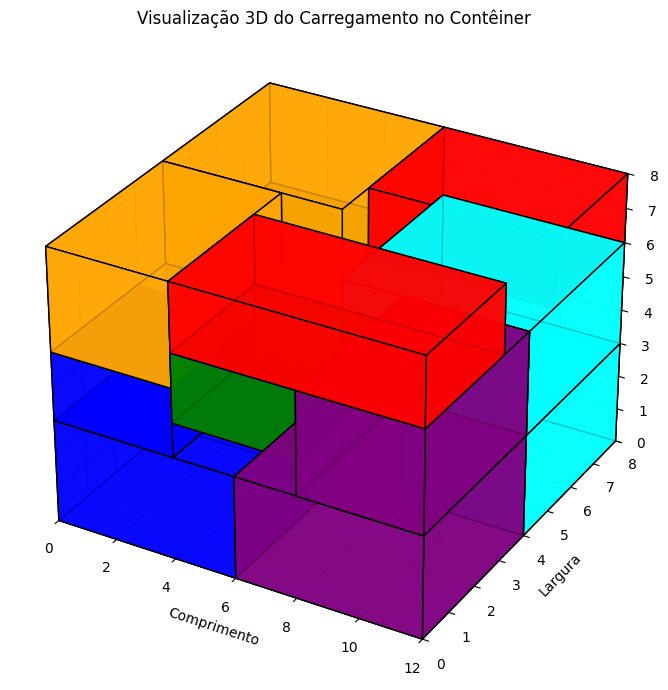

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Suponha que essas caixas foram carregadas, com as posições correspondentes
loaded_boxes = []
for (i, p, q, r), var in x.items():
    if var.X > 0.5:
        li, wi, hi, _ = boxes[i]
        loaded_boxes.append((p, q, r, li, wi, hi))

# Função para adicionar uma caixa à cena
def draw_box(ax, x, y, z, l, w, h, color):
    vertices = [
        [x, y, z],
        [x + l, y, z],
        [x + l, y + w, z],
        [x, y + w, z],
        [x, y, z + h],
        [x + l, y, z + h],
        [x + l, y + w, z + h],
        [x, y + w, z + h]
    ]
    faces = [
        [vertices[j] for j in [0,1,2,3]],
        [vertices[j] for j in [4,5,6,7]],
        [vertices[j] for j in [0,1,5,4]],
        [vertices[j] for j in [2,3,7,6]],
        [vertices[j] for j in [1,2,6,5]],
        [vertices[j] for j in [3,0,4,7]]
    ]
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, linewidths=1, edgecolors='k', alpha=0.8))

# Plotar
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Desenhar cada caixa carregada
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'yellow']
for i, (x, y, z, l, w, h) in enumerate(loaded_boxes):
    draw_box(ax, x, y, z, l, w, h, colors[i % len(colors)])

# Configurar limites e rótulos
ax.set_xlim(0, L)
ax.set_ylim(0, W)
ax.set_zlim(0, H)
ax.set_xlabel('Comprimento')
ax.set_ylabel('Largura')
ax.set_zlabel('Altura')
ax.set_title('Visualização 3D do Carregamento no Contêiner')

plt.tight_layout()
plt.show()


# 3) Vertical and Horizontal Stability Constraints

In [5]:
# ---------------------------
# Parâmetros do problema
# ---------------------------
L, W, H = 12, 8, 8  # dimensões do contêiner

# Caixas: (li, wi, hi, bi)
boxes = [
    (6, 3, 2, 2),
    (6, 4, 3, 5),
    (8, 3, 2, 3),
    (4, 3, 2, 2),
    (4, 4, 3, 3)
]

m = len(boxes)

# Conjuntos possíveis de posições (grid-based)
X = [range(L - li + 1) for (li, _, _, _) in boxes]
Y = [range(W - wi + 1) for (_, wi, _, _) in boxes]
Z = [range(H - hi + 1) for (_, _, hi, _) in boxes]

# ---------------------------
# Modelo
# ---------------------------
model = gp.Model("GridBasedPosition with vertical and horizontal stability constraints")

# Variáveis binárias x[i,p,q,r]
x = {}
for i in range(m):
    li, wi, hi, bi = boxes[i]
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                x[i, p, q, r] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{p}_{q}_{r}")

model.update()

# ---------------------------
# Função objetivo: maximizar volume total carregado
# ---------------------------
model.setObjective(
    gp.quicksum(
        (li * wi * hi) * x[i, p, q, r]
        for i, (li, wi, hi, bi) in enumerate(boxes)
        for p in X[i]
        for q in Y[i]
        for r in Z[i]
    ),
    GRB.MAXIMIZE
)

# ---------------------------
# Restrição 1: Não sobrepor caixas
# ---------------------------
for xp in range(L):
    for yq in range(W):
        for zr in range(H):
            covering_vars = []
            for i, (li, wi, hi, bi) in enumerate(boxes):
                for p in X[i]:
                    for q in Y[i]:
                        for r in Z[i]:
                            if p <= xp < p + li and q <= yq < q + wi and r <= zr < r + hi:
                                covering_vars.append(x[i, p, q, r])
            if covering_vars:
                model.addConstr(gp.quicksum(covering_vars) <= 1)

# ---------------------------
# Restrição 2: Quantidade máxima de cada tipo de caixa
# ---------------------------
for i, (li, wi, hi, bi) in enumerate(boxes):
    model.addConstr(
        gp.quicksum(x[i, p, q, r] for p in X[i] for q in Y[i] for r in Z[i]) <= bi
    )

# ---------------------------
# Restrição 3: Estabilidade Vertical
# ---------------------------
for i, (li, wi, hi, bi) in enumerate(boxes):
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                if r == 0:
                    continue  # já está apoiada no chão
                support_terms = []
                for j, (lj, wj, hj, bj) in enumerate(boxes):
                    if j == i:
                        continue
                    for p0 in X[j]:
                        for q0 in Y[j]:
                            # sobreposição em XY
                            Lij = min(p + li, p0 + lj) - max(p, p0)
                            Wij = min(q + wi, q0 + wj) - max(q, q0)
                            if Lij > 0 and Wij > 0 and (r - hj) in Z[j]:
                                support_terms.append(x[j, p0, q0, r - hj])
                if support_terms:
                    model.addConstr(
                        gp.quicksum(support_terms) >= x[i, p, q, r],
                        name=f"vert_stab_{i}_{p}_{q}_{r}"
                    )

# ---------------------------
# Restrição 4: Estabilidade Horizontal (Eixo X)
# ---------------------------
for i, (li, wi, hi, bi) in enumerate(boxes):
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                if p == 0 or p + li == L:
                    continue  # encostada na parede → estável
                support_terms = []
                for j, (lj, wj, hj, bj) in enumerate(boxes):
                    if j == i:
                        continue
                    for q0 in Y[j]:
                        for r0 in Z[j]:
                            Wij = min(q + wi, q0 + wj) - max(q, q0)
                            Hij = min(r + hi, r0 + hj) - max(r, r0)
                            if Wij > 0 and Hij > 0 and (p - lj) in X[j]:
                                support_terms.append(x[j, p - lj, q0, r0])
                if support_terms:
                    model.addConstr(
                        gp.quicksum(support_terms) >= x[i, p, q, r],
                        name=f"horiz_stabX_{i}_{p}_{q}_{r}"
                    )

# ---------------------------
# Restrição 5: Estabilidade Horizontal (Eixo Y)
# ---------------------------
for i, (li, wi, hi, bi) in enumerate(boxes):
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                if q == 0 or q + wi == W:
                    continue  # encostada na parede → estável
                support_terms = []
                for j, (lj, wj, hj, bj) in enumerate(boxes):
                    if j == i:
                        continue
                    for p0 in X[j]:
                        for r0 in Z[j]:
                            Lij = min(p + li, p0 + lj) - max(p, p0)
                            Hij = min(r + hi, r0 + hj) - max(r, r0)
                            if Lij > 0 and Hij > 0 and (q - wj) in Y[j]:
                                support_terms.append(x[j, p0, q - wj, r0])
                if support_terms:
                    model.addConstr(
                        gp.quicksum(support_terms) >= x[i, p, q, r],
                        name=f"horiz_stabY_{i}_{p}_{q}_{r}"
                    )

# ---------------------------
# Otimização
# ---------------------------
model.optimize()

# ---------------------------
# Mostrar solução
# ---------------------------
for i in range(m):
    li, wi, hi, bi = boxes[i]
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                if x[i, p, q, r].X > 0.5:
                    print(f"Caixa tipo {i} ({li}x{wi}x{hi}) colocada em ({p}, {q}, {r})")


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2545 rows, 1362 columns and 186840 nonzeros
Model fingerprint: 0x580cd0f3
Variable types: 0 continuous, 1362 integer (1362 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 600.0000000
Presolve removed 220 rows and 0 columns
Presolve time: 1.08s
Presolved: 2325 rows, 1362 columns, 175966 nonzeros
Variable types: 0 continuous, 1362 integer (1362 binary)

Root relaxation: objective 7.020000e+02, 1187 iterations, 0.24 seconds (0.20 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Ga

## 3.1) Visualization

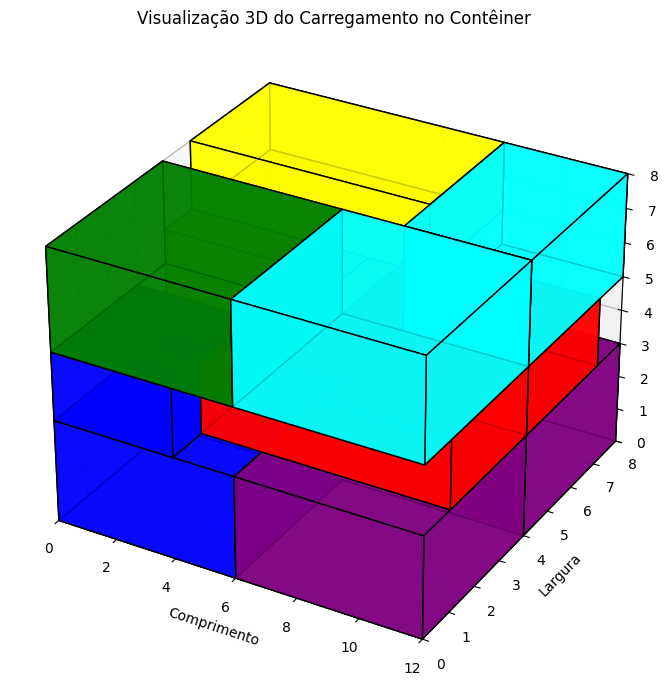

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Caixas carregadas na solução
loaded_boxes = []
for (i, p, q, r), var in x.items():
    if var.X > 0.5:  # A caixa foi escolhida
        li, wi, hi, _ = boxes[i]  # ignora o bi
        loaded_boxes.append((p, q, r, li, wi, hi))

# Função para desenhar cada caixa
def draw_box(ax, x, y, z, l, w, h, color):
    vertices = [
        [x, y, z],
        [x + l, y, z],
        [x + l, y + w, z],
        [x, y + w, z],
        [x, y, z + h],
        [x + l, y, z + h],
        [x + l, y + w, z + h],
        [x, y + w, z + h]
    ]
    faces = [
        [vertices[j] for j in [0,1,2,3]],
        [vertices[j] for j in [4,5,6,7]],
        [vertices[j] for j in [0,1,5,4]],
        [vertices[j] for j in [2,3,7,6]],
        [vertices[j] for j in [1,2,6,5]],
        [vertices[j] for j in [3,0,4,7]]
    ]
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, linewidths=1, edgecolors='k', alpha=0.8))

# Plotar
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Cores para diferenciar caixas
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'yellow']
for i, (x, y, z, l, w, h) in enumerate(loaded_boxes):
    draw_box(ax, x, y, z, l, w, h, colors[i % len(colors)])

# Configurações do gráfico
ax.set_xlim(0, L)
ax.set_ylim(0, W)
ax.set_zlim(0, H)
ax.set_xlabel('Comprimento')
ax.set_ylabel('Largura')
ax.set_zlabel('Altura')
ax.set_title('Visualização 3D do Carregamento no Contêiner')

plt.tight_layout()
plt.show()
